<a href="https://colab.research.google.com/github/pa-shk/iad-intro-ds-practical-tasks/blob/main/hw06_texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!kaggle datasets download nlp-getting-started/data -p /content/sample_data/ --unzip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 164, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import re
import string
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [ ]:
data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


In [ ]:
train.target.value_counts() / train.shape[0]

0    0.567461
1    0.432539
Name: target, dtype: float64

Классы рапределены довольно равномерно

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [ ]:
popular_keywords = list(train.keyword.value_counts().nlargest(10, 'all').keys())

In [ ]:
len(popular_keywords)

15

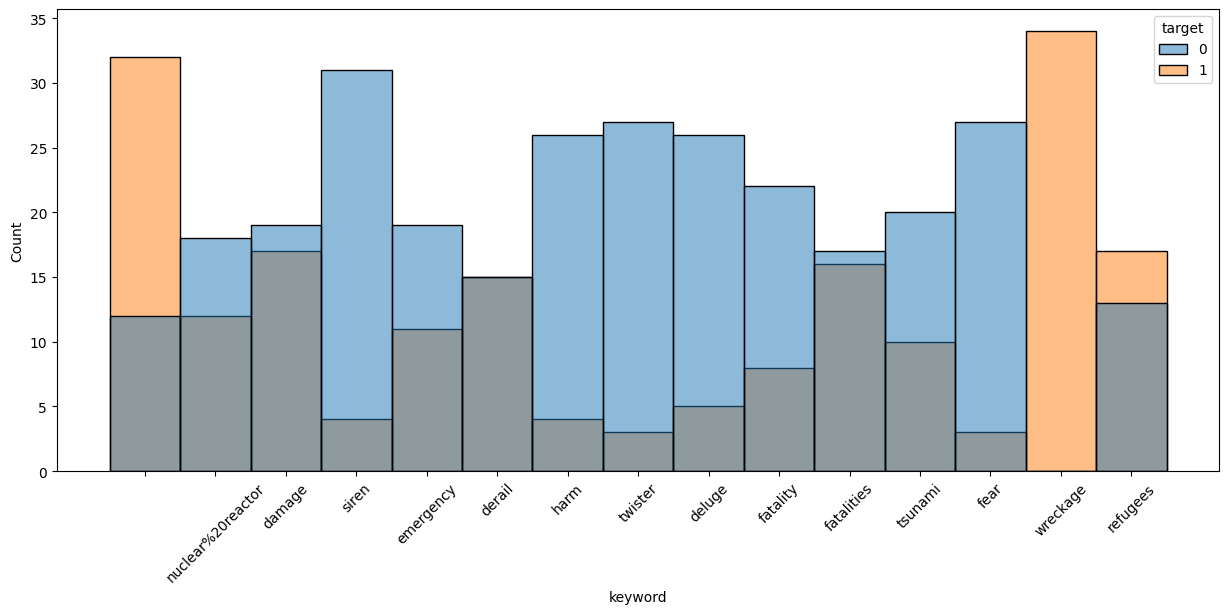

In [ ]:
fig = plt.figure(figsize=(15, 6))
fig = sns.histplot(data=train[train.keyword.isin(popular_keywords)], x="keyword", hue="target")
plt.xticks(rotation=45)
plt.show()

**NB** В данном  задании я решил сохранить примеры '' с отсутствующими ключевыми словами. Также, с учетом того, что несколько ключевых слов имеют одинаковую частотность, я посчитал более логичным проанализировать 15 наиболее часто встречающихся ключевых слов. Таким образом, мой график отличается от эталона, представленного в авторском решении

**Выводы**: Ключевое слово wreckage используется только в твитах о реальной катастрофе, refugees используется несколько чаще в твитах о катастрофах, derail встречается в одинаковом количестве твитов из каждой категории, fatalities и damage используются почти поровну с катастрофическими и обычными твитами с небольшим перевесом в пользу последних, хотя стоит учитывать, что обычных твитов в целом чуть больше в датасете. Для всех остальных ключевых слов преобладают твиты без катастроф. Наиболее "безопасные", т.е такие, для которых количество твитов о катастрофах значительно меньше, чем количество твитов не о катастрофах - sirien, twister, fear. Большинство твитов без ключевых слов - твиты о катастрофах.

## Задание 3 (0.5 балла)

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [ ]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [ ]:
train_new = train.drop(columns=['id', 'keyword', 'location'])
train_new.text = train[['keyword', 'location', 'text']].apply(' '.join, axis=1)

In [ ]:
train_new.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer()

print('Размер матрицы признаков:', bow.fit_transform(train.text).shape)

Размер матрицы признаков: (5329, 16937)


## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось?

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [ ]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return bool(re.search('\d', s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    for i in string.punctuation:
      if i in s:
        return True
    return False

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')

def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary):
    print('With digit:      ', sum(contains_digit(i) for i in vocabulary))
    print('With punctuation:', sum(contains_punctuation(i) for i in vocabulary))
    print('Hashtags:        ', sum(is_hashtag(i) for i in vocabulary))
    print('Mentions:        ', sum(is_mention(i) for i in vocabulary))

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(bow.vocabulary_)

With digit:       3663
With punctuation: 300
Hashtags:         0
Mentions:         0


In [ ]:
len(bow.vocabulary_)

16937

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось? ***3663***

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? ***300***

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре? ***0***

В нашем словаре не оказалось ни одного слова с упоминание или хештегом, так как по дефолту `CountVectorizer` использует следующий паттерн для выделения слов: `(?u)\b\w\w+\b`, так что все знаки препинания (и хештеги и упоминания), кроме `_` игнорируются

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [ ]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

In [ ]:
tweet_bow = CountVectorizer(tokenizer=TweetTokenizer().tokenize)
tweet_bow.fit_transform(train.text).shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 18080)

In [ ]:
# Пример рабаты TweetTokenizer
TweetTokenizer().tokenize('#Hello, @hello, good-bye:) 1, word2vec')

['#Hello', ',', '@hello', ',', 'good-bye', ':)', '1', ',', 'word', '2vec']

In [ ]:
# Токены, которые выделяет в данном предложений дефолтный токенайзер
CountVectorizer().fit(['#Hello, @hello, good-bye:) 1, word2vec']).vocabulary_.keys()

dict_keys(['hello', 'good', 'bye', 'word2vec'])

In [ ]:
len(tweet_bow.vocabulary_)

18080

In [ ]:
investigate_vocabulary(tweet_bow.vocabulary_)

With digit:       3781
With punctuation: 7136
Hashtags:         1440
Mentions:         1669


1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось? ***3781***

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? ***7136***

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре? ***3109***

**Сравнение:** Размер словаря увеличился, так как в него добавились слова с пунктуацией внутри, отдельные знаки препинания и последовательности знаков препинания, все хештеги и упоминания были сохранены. Также увеличилось кол-во слов содержащих цифры, что также связано с тем, как TweetTokenaizer делит слова: в отличие от дефолтного токенайзера он не игнорирует последовательности из одного символа, также, например, слово word2vec было разбито TweetTokenaizer'ом на два слова

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return bool(re.fullmatch('[a-zA-Z]+', s))

def is_emoji(s: str) -> bool:
    # Проверка, является ли слово смайликом
    return bool(re.fullmatch(f'[{re.escape(string.punctuation)}]+', s) and re.search(r'[\(\)]', s))

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return bool(re.fullmatch('#[a-zA-Z]+', s))

def custom_tokenizer(s: str) -> List[str]:
    # Кастомный токенайзер
    tokens = TweetTokenizer().tokenize(s.lower())
    tokens = [t for t in tokens if
              contains_only_latin_letters(t) or is_emoji(t) or is_hashtag(t)]
    tokens = [t for t in tokens if t not in nltk.corpus.stopwords.words('english')]
    return list(map(SnowballStemmer(language='english').stem, tokens))

In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [ ]:
train.head(10).text

1186    Ashes 2015: AustraliaÛªs collapse at Trent Br...
4071    GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @...
5461    CNN: Tennessee movie theater shooting suspect ...
5787    Still rioting in a couple of hours left until ...
7445    Crack in the path where I wiped out this morni...
151     Experts in France begin examining airplane deb...
915     'I came to kill Indians...for FUN': Video of s...
1305    @JohnsonTionne except idk them?? it's really b...
2570                                    destroy the house
7399    Police Officer Wounded Suspect Dead After Exch...
Name: text, dtype: object

In [ ]:
train.head(10).text.map(custom_tokenizer)

1186    [ash, australia, collaps, trent, bridg, among,...
4071    [great, michigan, techniqu, camp, thank, #gobl...
5461    [cnn, tennesse, movi, theater, shoot, suspect,...
5787              [still, riot, coupl, hour, left, class]
7445    [crack, path, wipe, morn, beach, run, surfac, ...
151     [expert, franc, begin, examin, airplan, debri,...
915     [came, kill, indian, fun, video, smirk, remors...
1305                          [except, idk, realli, burn]
2570                                      [destroy, hous]
7399    [polic, offic, wound, suspect, dead, exchang, ...
Name: text, dtype: object

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [ ]:
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)

X_train = vectorizer.fit_transform(train.text)
X_test = vectorizer.transform(test.text)

In [ ]:
X_train.shape

(5329, 9260)

2. Обучите LogisticRegression на полученных признаках.


In [ ]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, train.target)

LogisticRegression()

3. Посчитайте метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score


print('F1 score:', f1_score(test.target, lg.predict(X_test)))

F1 score: 0.7524644030668127


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
lg = LogisticRegression()

X_train = tf_vectorizer.fit_transform(train.text)
X_test = tf_vectorizer.transform(test.text)

lg.fit(X_train, train.target)

print('F1 score:', f1_score(test.target, lg.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7418803418803419


In [ ]:
X_train.shape

(5329, 9260)

1. **Ответ:** Качество уменьшилось

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [ ]:
tf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, max_df=0.9)
lg = LogisticRegression()

X_train = tf_vectorizer.fit_transform(train.text)
X_test = tf_vectorizer.transform(test.text)
lg.fit(X_train, train.target)

print('F1 score:', f1_score(test.target, lg.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7418803418803419


In [ ]:
X_train.shape

(5329, 9260)

2. **Ответ:** Ни качество, ни размер матрицы не изменились, так как, кажется, все токены в словаре имеют df ниже 0.9, поэтому данное ограничение ничего не изменило

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества?

Подберем оптимальное значение min_df по кросс-валидации

In [ ]:
from sklearn.model_selection import KFold

cv_res = {}
for min_df in [0.0001, 0.0005, 0.001, 0.01]:
  scores = []
  for train_index, val_index in KFold(n_splits=3, random_state=42, shuffle=True).split(train):
      train_train = train.iloc[train_index]
      train_val = train.iloc[val_index]

      tf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=min_df, max_df=0.9)
      lg = LogisticRegression()

      X_train = tf_vectorizer.fit_transform(train_train.text)
      X_val = tf_vectorizer.transform(train_val.text)
      lg.fit(X_train, train_train.target)
      scores.append(f1_score(train_val.target, lg.predict(X_val)))

  cv_res[min_df] = sum(scores) / len(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extr

In [ ]:
cv_res

{0.0001: 0.7151121857111452,
 0.0005: 0.71684561038551,
 0.001: 0.710467705638801,
 0.01: 0.6063017009372235}

In [ ]:
min_df = max(cv_res, key=cv_res.get)
min_df

0.0005

Проверим на тестовых данных

In [ ]:
tf_vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer, min_df=min_df, max_df=0.9)

lg = LogisticRegression()

X_train = tf_vectorizer.fit_transform(train.text)
X_test = tf_vectorizer.transform(test.text)
lg.fit(X_train, train.target)

print('F1 score:', f1_score(test.target, lg.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7550335570469799


In [ ]:
X_train.shape

(5329, 2788)

3. **Ответ:** Да, данный метод позволил улучшить качество. Размер словаря сократился

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, то мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(tokenizer=custom_tokenizer, n_features=5000)
lg = LogisticRegression()

X_train = hash_vectorizer.fit_transform(train.text)
X_test = hash_vectorizer.transform(test.text)

lg.fit(X_train, train.target)

print('F1 score:', f1_score(test.target, lg.predict(X_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7251864601262191


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** Наилучший результат был достигнут с помощью TfidfVectorizer и сокращения словаря путем подбора гиперпараметра min_df

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

Сделаем более мощный перебор гиперпараметров. В этом нам поможет Pipeline и RandomizedSearchCV

In [ ]:
from sklearn.pipeline import Pipeline

In [ ]:
pipe = Pipeline([
    ('count_vec', CountVectorizer()),
    ('tfidf_vec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear')),
])

In [ ]:
pipe.get_params()

{'memory': None,
 'steps': [('count_vec', CountVectorizer()),
  ('tfidf_vec', TfidfVectorizer()),
  ('logreg', LogisticRegression(solver='liblinear'))],
 'verbose': False,
 'count_vec': CountVectorizer(),
 'tfidf_vec': TfidfVectorizer(),
 'logreg': LogisticRegression(solver='liblinear'),
 'count_vec__analyzer': 'word',
 'count_vec__binary': False,
 'count_vec__decode_error': 'strict',
 'count_vec__dtype': numpy.int64,
 'count_vec__encoding': 'utf-8',
 'count_vec__input': 'content',
 'count_vec__lowercase': True,
 'count_vec__max_df': 1.0,
 'count_vec__max_features': None,
 'count_vec__min_df': 1,
 'count_vec__ngram_range': (1, 1),
 'count_vec__preprocessor': None,
 'count_vec__stop_words': None,
 'count_vec__strip_accents': None,
 'count_vec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'count_vec__tokenizer': None,
 'count_vec__vocabulary': None,
 'tfidf_vec__analyzer': 'word',
 'tfidf_vec__binary': False,
 'tfidf_vec__decode_error': 'strict',
 'tfidf_vec__dtype': numpy.float64,
 'tfidf_vec_

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
params = [{'tfidf_vec': ['passthrough'],
           'count_vec__lowercase': [True, False],
           'count_vec__ngram_range' : [(1, 1), (1, 2)],
           'count_vec__stop_words': ['english', None],
           'count_vec__min_df': [0.0001, 0.0005, 0.001, 0.01, 1],
           'logreg__C': [0.1, 1.0],
           'logreg__penalty': ['l1', 'l2']},

          {'tfidf_vec': ['passthrough'],
           'count_vec__lowercase': [True, False],
           'count_vec__ngram_range' : [(2, 3), (1, 3), (1, 5), (2, 4), (2, 5), (3, 6), (3, 5)],
           'count_vec__analyzer': ['char', 'char_wb'],
           'count_vec__min_df': [0.0001, 0.0005, 0.001, 0.01, 1],
           'logreg__C': [0.1, 1.0],
           'logreg__penalty': ['l1', 'l2']},

          {'count_vec': ['passthrough'],
           'tfidf_vec__lowercase': [True, False],
           'tfidf_vec__ngram_range' : [(1, 1), (1, 2)],
           'tfidf_vec__stop_words': ['english', None],
           'tfidf_vec__min_df': [0.0001, 0.0005, 0.001, 0.01, 1],
           'logreg__C': [0.1, 1.0],
           'logreg__penalty': ['l1', 'l2']},

          {'count_vec': ['passthrough'],
           'tfidf_vec__lowercase': [True, False],
           'tfidf_vec__ngram_range' : [(2, 3), (1, 3), (1, 5), (2, 4), (2, 5), (3, 6), (3, 5)],
           'tfidf_vec__analyzer': ['char', 'char_wb'],
           'tfidf_vec__min_df': [0.0001, 0.0005, 0.001, 0.01, 1],
           'logreg__C': [0.1, 1.0],
           'logreg__penalty': ['l1', 'l2']}]

rs = RandomizedSearchCV(pipe,
                        params,
                        scoring='f1',
                        n_jobs=-1,
                        refit=True,
                        random_state=42,
                        n_iter=30)

rs.fit(train.text, train.target)

RandomizedSearchCV(estimator=Pipeline(steps=[('count_vec', CountVectorizer()),
                                             ('tfidf_vec', TfidfVectorizer()),
                                             ('logreg',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions=[{'count_vec__lowercase': [True, False],
                                         'count_vec__min_df': [0.0001, 0.0005,
                                                               0.001, 0.01, 1],
                                         'count_vec__ngram_range': [(1, 1),
                                                                    (1, 2)],
                                         'count_vec__stop_words'...
                                                                    (1, 2)],
                                         'tfidf_vec__stop_words': ['english',
                                                                   None]},
                                        {'count_vec': ['passthrough'],
                                         'logreg__C': [0.1, 1.0],
                                         'logreg__penalty': ['l1', 'l2'],
                                         'tfidf_vec__analyzer': ['char',
                                                                 'char_wb'],
                                         'tfidf_vec__lowercase': [True, False],
                                         'tfidf_vec__min_df': [0.0001, 0.0005,
                                                               0.001, 0.01, 1],
                                         'tfidf_vec__ngram_range': [(2, 3),
                                                                    (1, 3),
                                                                    (1, 5),
                                                                    (2, 4),
                                                                    (2, 5),
                                                                    (3, 6),
                                                                    (3, 5)]}],
                   random_state=42, scoring='f1')

In [ ]:
rs.best_params_

{'tfidf_vec__ngram_range': (3, 5),
 'tfidf_vec__min_df': 0.001,
 'tfidf_vec__lowercase': True,
 'tfidf_vec__analyzer': 'char_wb',
 'logreg__penalty': 'l2',
 'logreg__C': 1.0,
 'count_vec': 'passthrough'}

In [ ]:
print('F1 score:', f1_score(test.target, rs.predict(test.text)))

F1 score: 0.7647389107243122


Извлечение признаков с помощью BERT

In [ ]:
!pip install transformers -q

In [ ]:
import torch

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_features(text):
  encoded_input = tokenizer(text, return_tensors='pt')
  with torch.no_grad():
    output = model(**encoded_input).last_hidden_state.numpy()
  return (output.sum(axis=1) / output.shape[1])[0]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_embeddings = train.text.map(get_bert_features)
test_embeddings = test.text.map(get_bert_features)
train_embeddings = np.array([i for i in train_embeddings])
test_embeddings = np.array([i for i in test_embeddings])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lg = LogisticRegression()
lg.fit(train_embeddings, train.target)
f1_score(test.target, lg.predict(test_embeddings))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7763713080168776

Что-то используемый алгоритм оптимизации не сошелся. Добавим стандартизацию признаков и регуляризацию

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)
test_embeddings = scaler.transform(test_embeddings)

cv = GridSearchCV(LogisticRegression(),
                  param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]},
                  scoring='f1',
                  refit=True)

cv.fit(train_embeddings, train.target)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]},
             scoring='f1')

In [ ]:
f1_score(test.target, cv.predict(test_embeddings))

0.7815845824411135